In [1]:
%matplotlib nbagg
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Levantando los datos

In [2]:
import main
raw_data = main.load_raw_data([]) # asume el cache
gdf = main.get_grouped_dataset(raw_data, level=4)

m, dfX = main.get_model_to_draw(4)

grouping for codigo_provincia,codigo_departamento,codigo_circuito,codigo_mesa
loading raw data..
grouping for codigo_provincia,codigo_departamento,codigo_circuito,codigo_mesa


# Patrones de voto

El análisis que presento sucintamente acá se basa en la hipótesis que la **distribución de votos en una mesa electoral permite describir a la población que votó allí**.

De esa forma podemos buscar **patrones** que ocurran a lo largo de todas las mesas electorales. 

Lo más sencillo es empezar por mirar la distribución conjunta, respondiendo a esta pregunta: 

### ¿Hay alguna correlación entre la cantidad de votos a Macri (135) y Scioli (131)? 


<IPython.core.display.Javascript object>


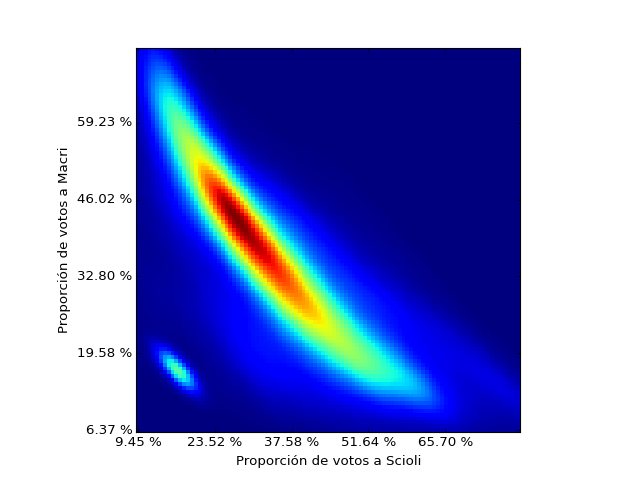

In [3]:
import model
figure()
distr = model.ConditionalDistribution(gdf['131_pct'], gdf['135_pct']).fit()
distr.draw_joint()
xlabel('Proporción de votos a Scioli'.decode('utf8'))
ylabel('Proporción de votos a Macri'.decode('utf8'))

**Hay una relación inversa entre la gente que votó a Macri y a Scioli**.
Eso ya lo sabemos. Otra cósa interesante que se puede ver, es que la zona más roja del gráfico corresponde aproximadamente al resultado final que obtuvieron los candidatos.

## La misma pregunta se puede hacer entre Scioli (131) y Massa (138)

<IPython.core.display.Javascript object>


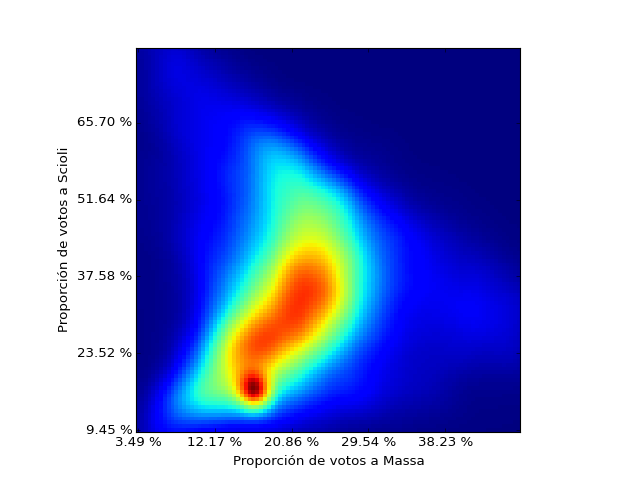

In [6]:
figure()
distr = model.ConditionalDistribution(gdf['138_pct'], gdf['131_pct']).fit()
distr.draw_joint()
xlabel('Proporción de votos a Massa'.decode('utf8'))
ylabel('Proporción de votos a Scioli'.decode('utf8'))

Este patrón es super interesante, parecería haber dos secciones, una donde  Massa tiene al rededor de 15%, y luego una cola, donde Massa tiene mayor cantidad de votos, y esa mayor cantidad de votos correlaciona con la cantidad de votos a Scioli.

## Por último, nos podemos hacer la misma pregunta entre Massa (138) y Macri (135)

<IPython.core.display.Javascript object>


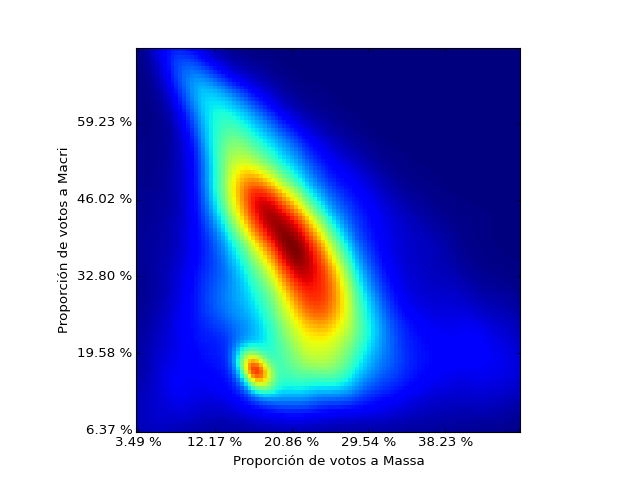

In [7]:
figure()
distr = model.ConditionalDistribution(gdf['138_pct'], gdf['135_pct']).fit()
distr.draw_joint()
xlabel('Proporción de votos a Massa'.decode('utf8'))
ylabel('Proporción de votos a Macri'.decode('utf8'))

Este es otro patrón muy interesante, tiene claramente una correlación negativa: A mayor cantidad de votos a Massa, menor a Macri.

# Predicción del Ballotage

Dicho mal y pronto, la idea es utilizar la información que se encuentra en estas distribuciones para estimar como se repartirían los votos, de forma tal que se respeten los patrones que observamos.

El proceso lo ejecuté agrupando en distintas granularidades. Como el proceso es lento, solo presento los resultados agrupando por Provincia y Departamento. 

In [29]:
level = 4

raw_data = main.load_raw_data([]) # asume el cache
gdf = main.get_grouped_dataset(raw_data, level=level)
totals = {}
for k in u'131', u'132', u'133', u'135', u'137', u'138':
    totals[k] = gdf[k].sum()

s = sum(totals.values())
# Como el proceso es lento, en lugar de ejecutarlo en este notebook, 
# se ejecuta en un proceso que guarda los resultados en una collection de mongodb
import main
row_id = max(main.save_collection.find({'level': level}).distinct('row_id'))
docs = list(main.save_collection.find({'level': level, 'row_id': row_id}))
print len(docs)

grouping for codigo_provincia,codigo_departamento,codigo_circuito,codigo_mesa
42


In [30]:
import pandas as pd
df = pd.DataFrame([e['pred'] for e in docs])
df['131_pct'] += totals['131']
df['135_pct'] += totals['135']
s = df['135_pct'] + df['131_pct']
df['131_pct_pct'] = df['131_pct'] / s
df['135_pct_pct'] = df['135_pct'] / s

<IPython.core.display.Javascript object>


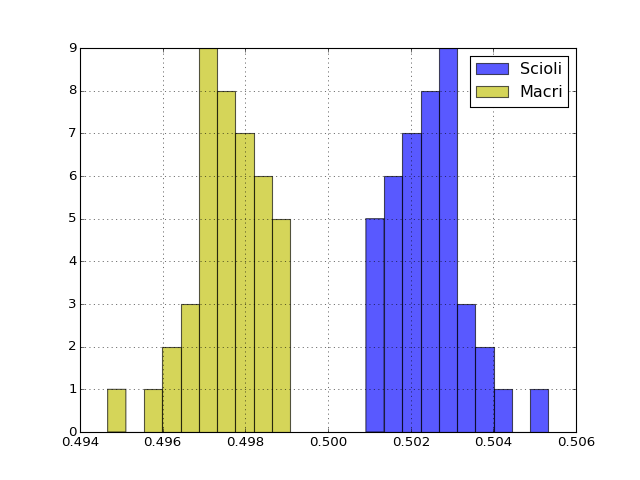

In [31]:
figure()
(df['131_pct_pct']).hist(alpha=0.65, color='b')
(df['135_pct_pct']).hist(alpha=0.65, color='y')
legend(('Scioli', 'Macri'))

Este resultado es bastante sorprendente. Hay dos posibles interpretaciones

 - O bien comentí un error en el análisis por haberlo hecho en poco tiempo
 - O bien según los datos de los votos en la probabilidad de que Macri le gane a Scioli es ínfima